# Eine fiktive Milonga

Open in Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/febse/opt2025-de/blob/main/Milonga.ipynb)

In einer Milonga gibt es 7 Männer und 5 Frauen. Die Teilnehmer kennen sich alle untereinander und haben bestimmte Präferenzen für Tanzpartner, die in dem Datensatz `dance` beschrieben sind. Finden Sie die beste Zuordnung von Tanzpaaren, so die Gesamtzufriedenheit aller Paare maximal ist (gemessen als die Summe der erfühlten Präferenzen).

In [27]:
%pip install gurobipy

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.


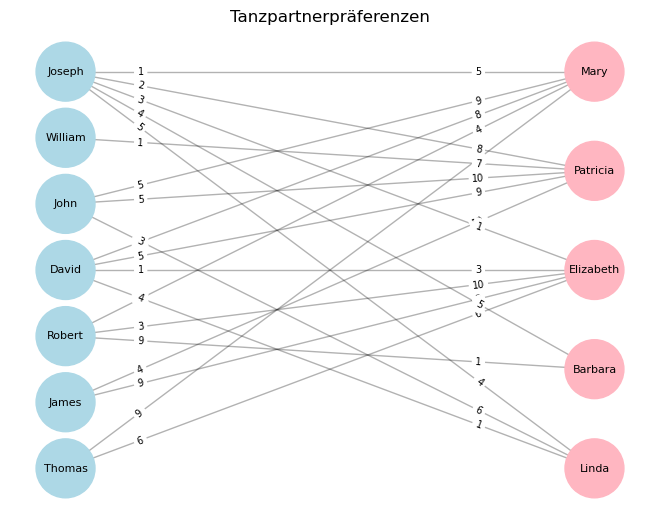

In [28]:
#| label: fig-milonga
#| fig-cap: Tanzpartnerpräferenzen
#| code-fold: true

random.seed(122)

# Generate random names for men and women
male_names = ["John", "Michael", "David", "James", "Robert", "William", "Joseph", "Charles", "Thomas"]
female_names = ["Mary", "Patricia", "Jennifer", "Linda", "Elizabeth", "Barbara", "Susan"]

# Create a bipartite graph
B = nx.Graph()

men_n = 7
women_n = 5

# Add nodes for men and women
men = random.sample(male_names, men_n)  # Randomly select 7 male names
women = random.sample(female_names, women_n)  # Randomly select 5 female names

B.add_nodes_from(men, bipartite=0)  # Add men to one set
B.add_nodes_from(women, bipartite=1)  # Add women to the other set

# Ensure every man is connected to at least one woman
edges = [(man, random.choice(women)) for man in men]

# Ensure every woman is connected to at least one man
edges += [(random.choice(men), woman) for woman in women]

# Add additional random edges to make the graph more connected
additional_edges = [
    (random.choice(men), random.choice(women)) for _ in range(men_n + women_n - 1)
]
edges += additional_edges

# Add edges to the graph with two sets of random weights
for edge in edges:
    B.add_edge(edge[0], edge[1], mPref=np.random.choice(range(1, 11), replace=False), wPref=np.random.choice(range(1, 11), replace=False))  # Assign two random weights

# Draw the bipartite graph
pos = nx.drawing.layout.bipartite_layout(B, men, scale=2)  # Position nodes in two layers

nx.draw(
    B, 
    pos, 
    with_labels=True, 
    node_color=["lightblue" if node in men else "lightpink" for node in B.nodes()],
    node_size=1800,  # Increase node size to fit names
    font_size=8,  # Reduce font size of the names
    edge_color=[(0, 0, 0, 0.3) for _ in B.edges()]
)

# Draw edge labels to show both preferences
edge_labels = nx.get_edge_attributes(B, 'mPref')
edge_labels2 = nx.get_edge_attributes(B, 'wPref')

# Combine both weights into a single label for display
# combined_labels = {edge: f"{edge_labels[edge]} / {edge_labels2[edge]}" for edge in edge_labels}
# nx.draw_networkx_edge_labels(B, pos, edge_labels=combined_labels, font_size=8)

nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels, font_size=7, label_pos=0.13)
nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels2, font_size=7, label_pos=0.79)

plt.title("Tanzpartnerpräferenzen")
plt.show()

Unsere Aufgabe hier ist es, die Tanzpartner so zuzuordnen, dass die Gesamtzufriedenheit aller Paare maximal ist.

Der Datensatz `dt` enthält die Präferenzen der Männer und der Frauen. Der Index des Datensatzes ist zwei-dimensional, wobei die erste Dimension den Namen des Mannes und die zweite Dimension den Namen der Frau enthält. Die Spalten `wPref` und `mPref` enthalten die Präferenzen der Frauen und der Männer

In [29]:
# Convert the graph to a pandas dataframe

dance = nx.to_pandas_edgelist(B).rename(columns = {"source": "man", "target": "woman"})
dance.set_index(["man", "woman"], inplace = True)
# Display the dataframe

dance["pref"] = dance["mPref"] + dance["wPref"]
dance

wPref  mPref  pref
man     woman                        
Thomas  Elizabeth      6      6    12
        Mary           3      9    12
James   Patricia      10      4    14
        Elizabeth      3      9    12
Robert  Barbara        1      9    10
        Elizabeth     10      3    13
        Mary           4      4     8
David   Mary           8      4    12
        Linda          1      4     5
        Elizabeth      3      1     4
        Patricia       9      5    14
John    Patricia      10      5    15
        Linda          6      3     9
        Mary           9      5    14
William Patricia       7      1     8
Joseph  Barbara        5      4     9
        Linda          4      5     9
        Patricia       8      2    10
        Mary           5      1     6
        Elizabeth      1      3     4

## Das Modell

## Mengen

$i \in M = \{1, \ldots, 7\}$: Menge der Männer

$j \in W = \{1, \ldots, 5\}$: Menge der Frauen

## Parameter

$\text{pMen}_{ij} \in \mathbb{R}$: Präferenz des Mannes $i$ für die Frau $j$

$\text{pWomen}_{ij} \in \mathbb{R}$: Präferenz der Frau $j$ für den Mann $i$

## Variablen

$\text{pair}_{ij} \in \{0, 1\}$: 1, falls Mann $i$ mit Frau $j$ ein Paar bildet, 0 sonst

## Zielsetzung

\begin{equation}
\max \sum_{i \in M} \sum_{j \in W} (\text{pMan}_{ij} + \text{pWoman}_{ij}  ) \cdot \text{pair}_{ij}
\end{equation}

## Nebenbedingungen

Jeder Man bildet ein Paar mit höchstens einer Frau:

\begin{equation}
\sum_{j \in W} \text{pair}_{ij} \leq 1 \quad \forall i \in M
\end{equation}

Jede Frau bildet ein Paar mit höchstens einem Mann:

\begin{equation}
\sum_{i \in M} \text{pair}_{ij} \leq 1 \quad \forall j \in W
\end{equation}





In [ ]:
dance.index.levels[0]

Index(['David', 'James', 'John', 'Joseph', 'Robert', 'Thomas', 'William'], dtype='object', name='men')

In [ ]:
dance.index.levels[1]

Index(['Barbara', 'Elizabeth', 'Linda', 'Mary', 'Patricia'], dtype='object', name='women')

In [ ]:
dance.index.levels[0]

Index(['David', 'James', 'John', 'Joseph', 'Robert', 'Thomas', 'William'], dtype='object', name='men')

In [9]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model('Milonga')
# m.Params.LogToConsole = 0

# Create variables

x = m.addVars(dance.index, vtype=GRB.BINARY, name="pair")

# Zielfunktion

m.setObjective(x.prod(dance["pref"].to_dict()), GRB.MAXIMIZE)

# Jeder Mann wird höchstens einer Frau zugewiesen

c_men = m.addConstrs((x.sum(man, '*') <= 1 for man in dance.index.levels[0]), name="Men")

c_women = m.addConstrs((x.sum('*', woman) <= 1 for woman in dance.index.levels[1]), name="Women")

m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 12 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x57ac8e69
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 45.0000000
Presolve removed 4 rows and 10 columns
Presolve time: 0.00s
Presolved: 8 rows, 10 columns, 20 nonzeros
Found heuristic solution: objective 58.0000000
Variable types: 0 continuous, 10 integer (10 binary)
Found heuristic solution: objective 61.0000000

Root relaxation: objective 6.700000e+01, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl 

In [24]:
# # Lösung ausgeben als pandas DataFrame

dance["isDancing"] = [(v.x) for v in m.getVars()]
dance.reset_index(inplace=True)
dance

,index,man,woman,wPref,mPref,pref,isDancing
0,0,Thomas,Elizabeth,2,7,9,0.0
1,1,Thomas,Mary,4,10,14,0.0
2,2,James,Patricia,2,8,10,0.0
3,3,James,Elizabeth,6,6,12,1.0
4,4,Robert,Barbara,10,4,14,0.0
5,5,Robert,Elizabeth,8,6,14,-0.0
6,6,Robert,Mary,10,7,17,1.0
7,7,David,Mary,4,1,5,0.0
8,8,David,Linda,8,1,9,1.0
9,9,David,Elizabeth,4,9,13,-0.0


## Analyse der Lösung

- Wie viele Paare wurden gebildet? Das ist zwar trivial, der Punkt ist aber, dass Sie das mit `pandas` herausfinden.
- Wer bleibt ohne Partner?
- Wie viele Tänzer haben mit ihrem Wunschpartner getanzt?


In [ ]:
# sol = solution.reset_index()

# sol["IsDancing"] = sol.groupby("man")["Paar"].transform("sum")
# sol[sol["IsDancing"] == 0]["man"].unique()

In [24]:
# m.write('Tanzpaare.lp')

# with open('Tanzpaare.lp', 'r') as f:
#     print(f.read())
